# <strong style="font-size:40px"> Walkthrough - Valuación de inmuebles en un sistema de búsqueda online - ECI 2018 - Navent </strong>

# Agenda:
* Análisis exploratorio básico
* Presentación de tres modelos súper simples.
* Código para hacer un submit real

# Análisis exploratorio

El dataset son propiedades en `venta` en México entre `2012` y `2016`, valuadas en `pesos mexicanos`. El csv de train tiene `240K` filas y `22` columnas. El csv de test tiene `60K` filas (y 21 columnas). La columna a predecir es `precio`.

In [1]:
# Importamos librerías de análisis de datos
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('mode.chained_assignment', None) # Deshabilita SettingWithCopyWarning. Ojo.

## General

In [2]:
# Cargamos el dataframe
df = pd.read_csv('train.csv', index_col='id', parse_dates=['fecha'])

In [3]:
print(f"Shape: {df.shape}")
print(f"Columnas: {df.columns}")
df.head()

Shape: (240000, 22)
Columnas: Index(['titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')


,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
id,,,,,,,,,,,,,,,,,,,,,,
254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,nan,2.00,1.00,2.00,80.00,80.00,23533.00,nan,nan,2015-08-23,0.00,0.00,0.00,0.00,0.00,2273000.00
53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.00,3.00,2.00,2.00,268.00,180.00,24514.00,19.31,-99.23,2013-06-28,0.00,0.00,0.00,1.00,1.00,3600000.00
247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.00,3.00,2.00,2.00,144.00,166.00,48551.00,nan,nan,2015-10-17,0.00,0.00,0.00,0.00,0.00,1200000.00
209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.00,2.00,1.00,1.00,63.00,67.00,53666.00,19.30,-99.69,2012-03-09,0.00,0.00,0.00,1.00,1.00,650000.00
185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.00,2.00,1.00,1.00,95.00,95.00,47835.00,nan,nan,2016-06-07,0.00,0.00,0.00,0.00,0.00,1150000.00


| Columnas de texto | Tipo | Comentarios | 
|:-|:-|:- | 
|`titulo`| Texto | El título de la propiedad publicada |
|`descripcion`| Texto | La descripción de la propieadad publicada |

| Localización | Tipo | Comentarios | 
|:-|:-|:- | 
|`direccion` | String | La dirección (calle y número) de la propiedad |
|`ciudad`| String |  La ciudad de la propiedad |
|`idzona`| Int |  Una zona es una parte de un ciudad |
|`provincia`| String  | La provincia donde está localizada la propiedad|
|`lat`| Float | Latitud |
|`lng`| Float | Longitud|

| Cualidad | Tipo | Comentarios | 
|:-|:-|:- | 
| `tipodepropiedad` | Categórico (String) | Casa, apartamento, terreno, etc|
| `metrostotales` | Int | Metros totales de la propiedad | 
| `metroscubiertos` | Int | Metros cubiertos de la propiedad |
| `antiguedad` | Int | Antigüedad de la propiedad |
| `habitaciones` | Int | Cantidad de habitaciones |
| `garages` | Int | Cantidad de garages |
| `banos` | Int | Cantidad de baños|

| Fecha/Amenities/Otros | Tipo | Comentarios | 
|:-|:-|:- | 
| `fecha` | Date | Fecha de publicación |
| `gimnasio` |  Bool | Si el edificio o la propiedad tiene un gimnasio |
| `usosmultiples` |  Bool |Si el edificio o la propiedad tiene un SUM |
| `piscina` |  Bool | Si el edificio o la propiedad tiene un piscina |
| `escuelascercanas` |  Bool |Si la propiedad tiene escuelas cerca |
| `centroscomercialescercanos` | Bool | Si la propiedad tiene centros comerciales cerca |

| Variable dependiente | Tipo | Comentarios | 
|:-|:-|:- | 
| `precio` | Float | Valor de publicación de la propiedad en pesos mexicanos |

## Datos faltantes

El dataset está tomado directamente de la página y tiene muchos datos faltantes o mal cargados. Lo curamos un poco, pero sigue teniendo mucho ruido. Por ejemplo, latitud y longitud solo están presentes en el 48% de los datos, dirección y metros totales faltan para el ~20%, etc. Además de los nulls, pueden encontrar cosas sin sentido que responden a cargas negligentes de los datos.

In [5]:
nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['nulls'])
nulls['porcentaje'] = round(100*nulls['nulls'] / len(df), 2)
nulls

,nulls,porcentaje
precio,0,0.00
escuelascercanas,0,0.00
piscina,0,0.00
usosmultiples,0,0.00
gimnasio,0,0.00
fecha,0,0.00
centroscomercialescercanos,0,0.00
tipodepropiedad,46,0.02
provincia,155,0.06
ciudad,372,0.16


## Precio

El precio tiene una distribución asimétrica positiva (a izquierda) con long-tail. A modo heurístico, la tasa USD2MXN hoy es de ~20. O sea que 2.000.000 MXN serían 100.000 USD y 12.000.000 MXN, 600.000 USD.

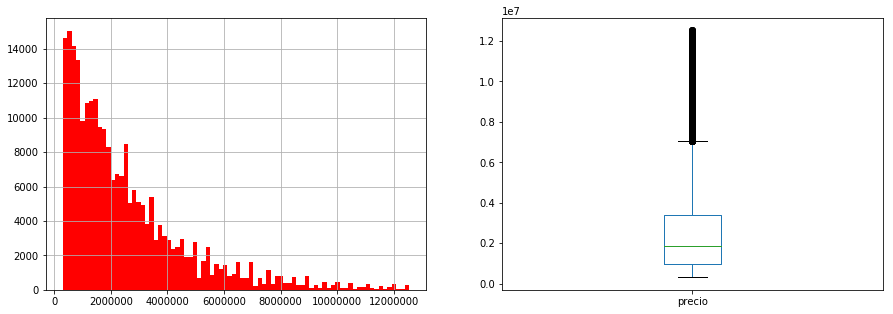

In [8]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].ticklabel_format(style = 'plain')
df['precio'].hist(bins=80, ax=axes[0], color='r'); 
#np.log(df['precio']).hist(bins=80, ax=axes[0], color='g'); 
df['precio'].plot(kind='box', ax=axes[1]);
plt.show()

## Tipos de propiedad

Tipos de propiedad y precio promedio por tipo de propiedad

Total tipos de propiedad: 24


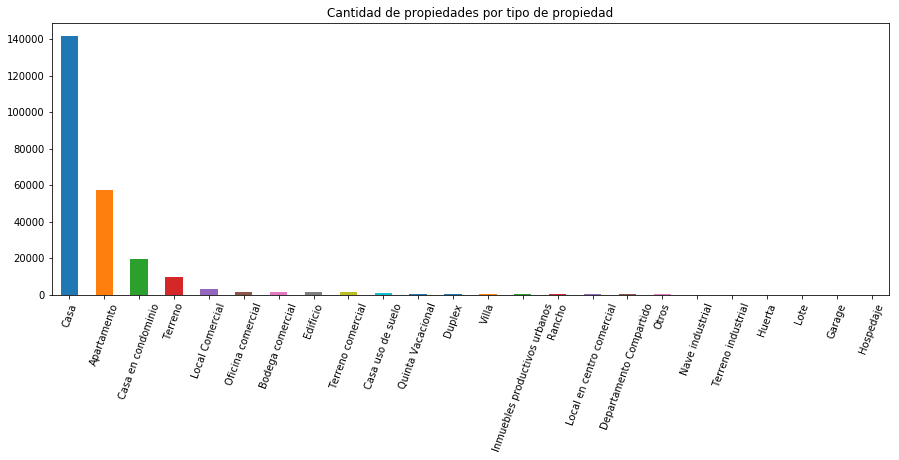

In [9]:
print(f"Total tipos de propiedad: {df.tipodepropiedad.nunique()}")
df.tipodepropiedad.value_counts().plot(kind='bar', figsize=(15, 5), rot=70, 
                                       title="Cantidad de propiedades por tipo de propiedad");

In [10]:
# Precio promedio por tipo de propiedad
#df.groupby('tipodepropiedad').agg({'precio': 'mean'})\
#    .sort_values('precio', ascending=False)\
#    .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por tipo de propiedad");

## Provincias

Total de provincias: 32


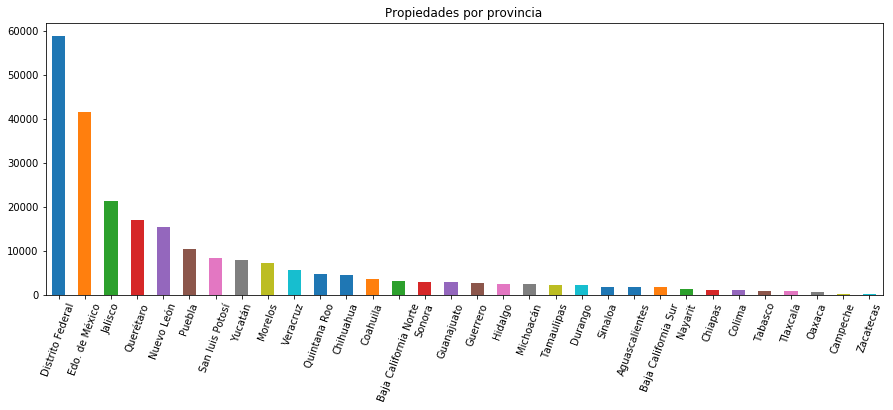

In [11]:
print(f"Total de provincias: {df.provincia.nunique()}")
df.provincia.value_counts().plot(kind='bar', figsize=(15, 5), rot=70, title="Propiedades por provincia");

## Precio por provincia

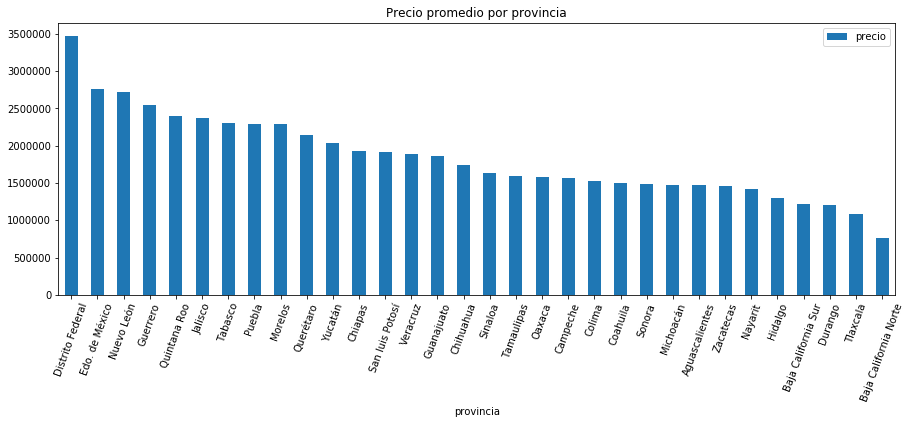

In [12]:
df.groupby('provincia').agg({'precio': 'mean'})\
    .sort_values('precio', ascending=False)\
    .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por provincia");

In [13]:
print(f"Total de ciudades: {df.ciudad.nunique()}")
df.ciudad.value_counts().head(10)

Total de ciudades: 875


Querétaro              12646
Benito Juárez          11014
Zapopan                10360
San Luis Potosí         7925
Mérida                  7162
Monterrey               6946
Alvaro Obregón          6633
Cuauhtémoc              6614
Naucalpan de Juárez     6554
Miguel Hidalgo          5795
Name: ciudad, dtype: int64

## Correlaciones

Dos variables se correlacionan positivamente si cuando una crece, la otra crece también y se correlacionan negativamente si cuando una crece, la otra decrece. En realidad, la relación es más débil: se correlacionan si, al aumentar una, la otra *tiende* a aumentar, en general. 

Como ahora vamos a ver, el precio y los metros cubiertos se correlacionan positivamente (lo que significa que las propiedades más grandes tienden a ser más caras que las más chicas...)


*NB: Correlación no implica causalidad*.

In [14]:
# Agrego dos columnas calculadas a partir de la fecha (timestamp y 201602,...)
df['ts'] = df.fecha.astype(int)
df['anio_mes'] = df['fecha'].map(lambda x: 100 * x.year + x.month)

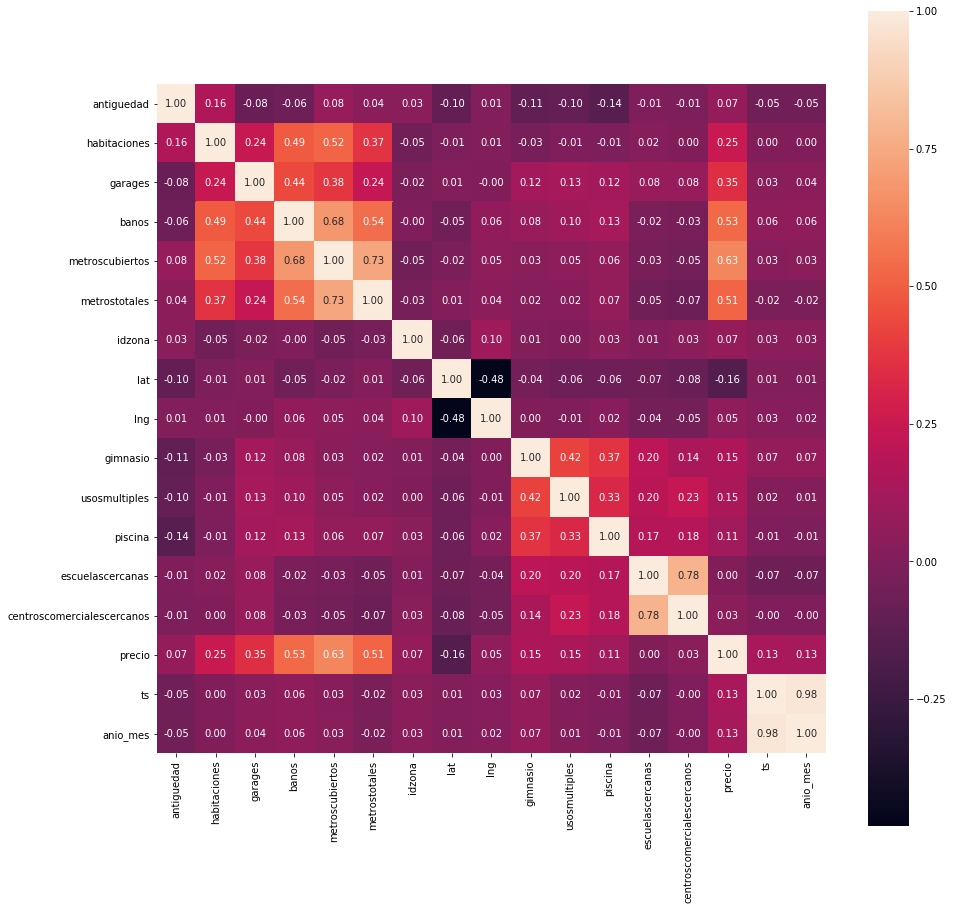

In [15]:
# Matriz de correlaciones como heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f');

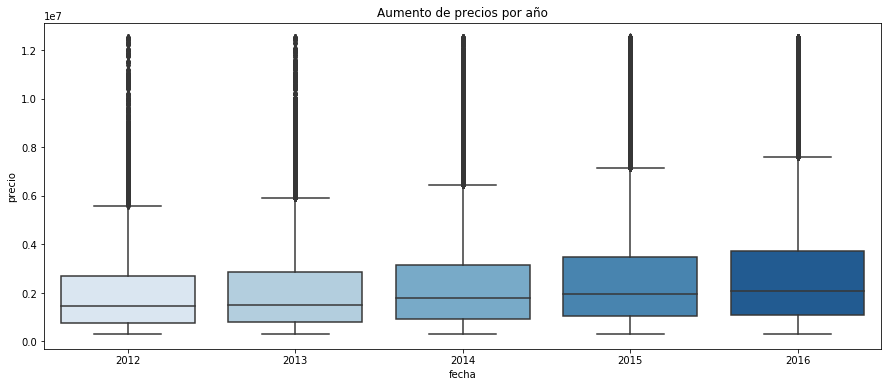

In [16]:
# Inflación mexicana
plt.figure(figsize=(15, 6))
sns.boxplot(x=df.fecha.dt.year, y='precio', data=df, palette='Blues')
plt.title("Aumento de precios por año");

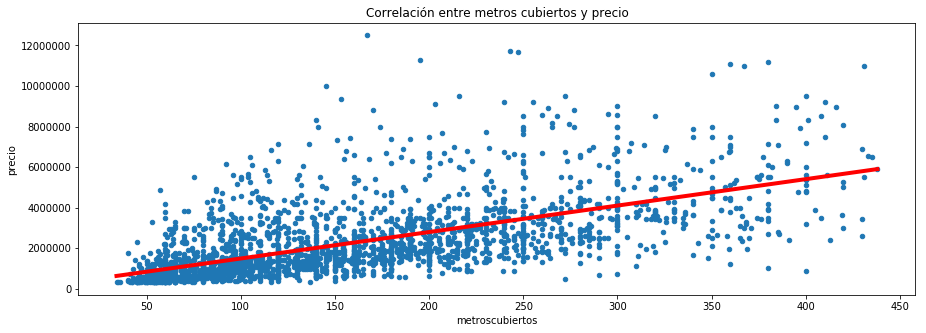

In [17]:
# Correlacion entre precio y metros cubiertos: descripción gráfica
column = 'metroscubiertos'

# Scatter plot
df_sample = df.sample(frac=0.05).copy().dropna().sort_values(column)
df_sample.plot.scatter(x=column, y='precio', figsize=(15, 5), title="Correlación entre metros cubiertos y precio")
plt.ticklabel_format(style = 'plain')

# Best-fit lineal
x = df_sample[column]
y = df_sample['precio']
f = np.poly1d(np.polyfit(x, y, deg=1))  
plt.plot(x.unique(), f(x.unique()), c='r', linewidth=4);

In [18]:
# Distribución de metros cubiertos
# _, axes = plt.subplots(1, 2, figsize=(15, 5))
# plt.ticklabel_format(style = 'plain')
# df[column].hist(bins=40, ax=axes[0], color='orange');
# df[column].plot(kind='box', ax=axes[1]);

---

# Modelos baseline

In [19]:
# Importamos utilidades y modelos de sklearn
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Métrica: Root Mean Squared Logarithmic Error
$
\huge
\begin{align}
RMSLE = \sqrt{\frac{\sum((log(\text{actual}+1) - log(\text{pred}+1))^2}{n}}
\end{align}
$

In [20]:
# Métrica de evaluación
def RMSLE(actual, pred):
    return (np.mean((np.log(actual + 1) - np.log(pred + 1)) ** 2)) **.5

#### Intuición detrás de RMSLE

La razón para usar error logarítmico es que relativiza el error al valor absoluto considerado. Por ejemplo, consideremos un error absoluto de 1000 sobre un valor absoluto de 10 y uno de 100.000:

In [22]:
actual_1 = 10
actual_2 = 1000000
error = 1000

abs_error_1 = np.abs(actual_1 - (actual_1 + error))
abs_error_2 = np.abs(actual_2 - (actual_2 + error))

log_error_1 = np.abs(np.log(actual_1 + 1) - np.log(actual_1 + error + 1))
log_error_2 = np.abs(np.log(actual_2 + 1) - np.log(actual_2 + error + 1))

print(f"Error relativo grande - Abs: {abs_error_1:.4f}, Log:{log_error_1:.4f}")
print(f"Error relativo chico  - Abs: {abs_error_2:.4f}, Log:{log_error_2:.4f}")

Error relativo grande - Abs: 1000.0000, Log:4.5208
Error relativo chico  - Abs: 1000.0000, Log:0.0010


## Baseline 1: [DummyRegressor](http://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)

Un DummyRegressor(strategy='mean') predice el precio promedio del train set (como constante), no es verdaderamente útil, pero sirve como baseline para darse una idea del bottom-line de valores de predicción

### Preprocesamiento

In [23]:
# Tiramos todas las columnas no numéricas para que sklearn nos acepte el dataframe. 
# Igualmente, el DummyRegressor no va a utilizar ninguna más que el precio 
drop_cols = ['fecha', 'ciudad', 'idzona', 'tipodepropiedad', 'provincia', 'titulo', 'descripcion', 'direccion']
X = df.drop(['precio'] + drop_cols, axis=1)
y = df['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print(f"Train shapes: X={X_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={X_test.shape}  y={y_test.shape}")

Train shapes: X=(180000, 15) y=(180000,)
Test  shapes: X=(60000, 15)  y=(60000,)


### Modelo

In [25]:
dummy = DummyRegressor(strategy='mean').fit(X_train, y_train)
pred = dummy.predict(X_test)

In [26]:
print(f"Promedio de precios del train set: {y_train.mean()}")
print(f"Primeras 3 predicciones: {pred[:3]}")

Promedio de precios del train set: 2536913.142061111
Primeras 3 predicciones: [2536913.14206111 2536913.14206111 2536913.14206111]


In [27]:
dummy_rmsle = RMSLE(y_test, pred)
dummy_rmsle_train = RMSLE(y_train, dummy.predict(X_train))
print(f"RMSLE DummyRegressor (train): {dummy_rmsle_train:.5f}")
print(f"RMSLE DummyRegressor: {dummy_rmsle:.5f}")

RMSLE DummyRegressor (train): 0.90228
RMSLE DummyRegressor: 0.90318


#### RMSLE no tiene cota superior, asi que 0.903 no es tan malo

In [29]:
rmsle_1 = RMSLE(y_test, np.array([1 for _ in range(len(y_test))]))
rmsle_inf = RMSLE(y_test, np.array([9999999999999999999 for _ in range(len(y_test))]))
print(f"Si predijesemos todo 1 el RMSLE sería: {rmsle_1:.4f}")
print(f"Si predijesemos un valor altísimo, sería: {rmsle_inf:.4f}")

Si predijesemos todo 1 el RMSLE sería: 13.7364
Si predijesemos un valor altísimo, sería: 29.3569


## Baseline 2: Regresión lineal sobre metros cubiertos

### Preprocesamiento

In [30]:
X = df[['metroscubiertos']]
y = df['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print(f"Train shapes: X={X_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={X_test.shape}  y={y_test.shape}")

Train shapes: X=(180000, 1) y=(180000,)
Test  shapes: X=(60000, 1)  y=(60000,)


#### Imputación de nulls
Un [Imputer](http://scikit-learn.org/stable/modules/preprocessing.html#imputation) ("imputador") es una manera de rellenar los nulls  un poco más sofisticada que reemplazarlos por 0 o por -1 (o tirarlos).

En este caso, reemplazamos los nulls por el valor promedio de las muestras existentes, pero podríamos reemplazarlos por otro valor (la moda, la mediana, etc).

Acá imputamos los metros cubiertos.

**OJO!** Al tomar el promedio (`fittear`) hay que hacerlo sobre el train set, sino estaríamos leakeando información!

In [31]:
imp = Imputer()
X_train['metroscubiertos'] = imp.fit_transform(X_train[['metroscubiertos']])
X_test['metroscubiertos'] = imp.transform(X_test[['metroscubiertos']])

In [33]:
X_test.isnull().sum()

metroscubiertos    0
dtype: int64

### Modelo

In [34]:
linear_model = LinearRegression().fit(X_train, y_train)
pred = linear_model.predict(X_test)

In [37]:
# El modelo de regresion lineal con una variable obtiene RMSLE=0.65
linear_rmsle_train = RMSLE(y_train, linear_model.predict(X_train))
linear_rmsle = RMSLE(y_test, pred)
print(f"RMSLE LinearRegression (train): {linear_rmsle_train:.5f}")
print(f"RMSLE LinearRegression: {linear_rmsle:.5f}")

RMSLE LinearRegression (train): 0.65673
RMSLE LinearRegression: 0.65657


## Baseline 3: Árbol de decisión sobre varios features

### Preprocesamiento

In [39]:
# Droppeamos strings y columnas complejas y repetidas
drop_cols = ['titulo', 'descripcion', 'direccion', 'lat', 'lng', 'fecha', 'ts', 'idzona']
df2 = df.drop(drop_cols, axis=1).copy()
print(f"Columnas ({len(df2.columns)}): {df2.columns.tolist()}")
df2.head()

Columnas (16): ['tipodepropiedad', 'ciudad', 'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'precio', 'anio_mes']


,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,anio_mes
id,,,,,,,,,,,,,,,,
254099,Apartamento,Benito Juárez,Distrito Federal,nan,2.00,1.00,2.00,80.00,80.00,0.00,0.00,0.00,0.00,0.00,2273000.00,201508
53461,Casa en condominio,La Magdalena Contreras,Distrito Federal,10.00,3.00,2.00,2.00,268.00,180.00,0.00,0.00,0.00,1.00,1.00,3600000.00,201306
247984,Casa,Tonalá,Jalisco,5.00,3.00,2.00,2.00,144.00,166.00,0.00,0.00,0.00,0.00,0.00,1200000.00,201510
209067,Casa,Zinacantepec,Edo. de México,1.00,2.00,1.00,1.00,63.00,67.00,0.00,0.00,0.00,1.00,1.00,650000.00,201203
185997,Apartamento,Zapopan,Jalisco,10.00,2.00,1.00,1.00,95.00,95.00,0.00,0.00,0.00,0.00,0.00,1150000.00,201606


#### Observamos nulls y de features categóricos

In [40]:
display(df2.isnull().sum())
numeric_columns_with_nulls = list(set(df2.columns[df2.isnull().sum() > 0].tolist()) \
                                  - set(['tipodepropiedad', 'ciudad', 'provincia']))
print(numeric_columns_with_nulls)

tipodepropiedad                  46
ciudad                          372
provincia                       155
antiguedad                    43555
habitaciones                  22471
garages                       37765
banos                         26221
metroscubiertos               17400
metrostotales                 51467
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
anio_mes                          0
dtype: int64

['habitaciones', 'garages', 'antiguedad', 'metroscubiertos', 'metrostotales', 'banos']


#### One-hot-encodeamos los categóricos [`tipodepropiedad`, `ciudad` y `provincia`] sobre todo el dataset

In [42]:
# Con dummy_na=True, creamos la categoria "Es nulo" como una coordenada más de los one-hot vectors
# Comentar: ¿Hay leaks acá? ¿Sí / No? ¿Por qué?
df2 = pd.get_dummies(df2, dummy_na=True)
print(f"Cantidad de columnas después del one-hot-encoding: {len(df2.columns)}")
df2.head()

Cantidad de columnas después del one-hot-encoding: 947


,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,anio_mes,tipodepropiedad_Apartamento,tipodepropiedad_Bodega comercial,tipodepropiedad_Casa,tipodepropiedad_Casa en condominio,tipodepropiedad_Casa uso de suelo,tipodepropiedad_Departamento Compartido,tipodepropiedad_Duplex,tipodepropiedad_Edificio,tipodepropiedad_Garage,tipodepropiedad_Hospedaje,tipodepropiedad_Huerta,tipodepropiedad_Inmuebles productivos urbanos,tipodepropiedad_Local Comercial,tipodepropiedad_Local en centro comercial,tipodepropiedad_Lote,tipodepropiedad_Nave industrial,tipodepropiedad_Oficina comercial,tipodepropiedad_Otros,tipodepropiedad_Quinta Vacacional,tipodepropiedad_Rancho,tipodepropiedad_Terreno,tipodepropiedad_Terreno comercial,tipodepropiedad_Terreno industrial,tipodepropiedad_Villa,tipodepropiedad_nan,ciudad_Abalá,ciudad_Abasolo,ciudad_Abejones,ciudad_Acajete,ciudad_Acambay,ciudad_Acaponeta,ciudad_Acapulco de Juárez,ciudad_Acateno,ciudad_Acatic,ciudad_Acatzingo,ciudad_Acayucan,ciudad_Acolman,...,ciudad_Zimapán,ciudad_Zimatlán de Alvarez,ciudad_Zinacantepec,ciudad_Zinapécuaro,ciudad_Zináparo,ciudad_ZirAndaro,ciudad_Zitácuaro,ciudad_Zumpahuacán,ciudad_Zumpango,ciudad_otra,ciudad_ácatlán,ciudad_ácatlán de Juárez,ciudad_ácaxochitlán,ciudad_ácámbaro,ciudad_áutlán de Navarro,ciudad_áyotlán,ciudad_nan,provincia_Aguascalientes,provincia_Baja California Norte,provincia_Baja California Sur,provincia_Campeche,provincia_Chiapas,provincia_Chihuahua,provincia_Coahuila,provincia_Colima,provincia_Distrito Federal,provincia_Durango,provincia_Edo. de México,provincia_Guanajuato,provincia_Guerrero,provincia_Hidalgo,provincia_Jalisco,provincia_Michoacán,provincia_Morelos,provincia_Nayarit,provincia_Nuevo León,provincia_Oaxaca,provincia_Puebla,provincia_Querétaro,provincia_Quintana Roo,provincia_San luis Potosí,provincia_Sinaloa,provincia_Sonora,provincia_Tabasco,provincia_Tamaulipas,provincia_Tlaxcala,provincia_Veracruz,provincia_Yucatán,provincia_Zacatecas,provincia_nan
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
254099,nan,2.00,1.00,2.00,80.00,80.00,0.00,0.00,0.00,0.00,0.00,2273000.00,201508,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53461,10.00,3.00,2.00,2.00,268.00,180.00,0.00,0.00,0.00,1.00,1.00,3600000.00,201306,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
247984,5.00,3.00,2.00,2.00,144.00,166.00,0.00,0.00,0.00,0.00,0.00,1200000.00,201510,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209067,1.00,2.00,1.00,1.00,63.00,67.00,0.00,0.00,0.00,1.00,1.00,650000.00,201203,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
185997,10.00,2.00,1.00,1.00,95.00,95.00,0.00,0.00,0.00,0.00,0.00,1150000.00,201606,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Ejemplo de one-hot-encoding (pasar categóricos a `dummies`)

In [46]:
one_hot_encoding_example_df = pd.DataFrame(['red', 'red', 'green', 'blue', np.nan], columns=['color'])
display(one_hot_encoding_example_df)
display(pd.get_dummies(one_hot_encoding_example_df))
display(pd.get_dummies(one_hot_encoding_example_df, dummy_na=True))

,color
0,red
1,red
2,green
3,blue
4,NaN


,color_blue,color_green,color_red
0,0,0,1
1,0,0,1
2,0,1,0
3,1,0,0
4,0,0,0


,color_blue,color_green,color_red,color_nan
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,1,0,0,0
4,0,0,0,1


Más sobre one-hot-encoding [acá](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding)

#### Imputación de nulls numéricos

In [43]:
# Para los nulls numéricos, usar un Imputer con strategy mean (reemplazamos los NaN por el promedio)
# Para no leakear, spliteamos el dataset antes
X2 = df2.drop("precio", axis=1)
y2 = df2['precio']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=1)

In [44]:
for c in numeric_columns_with_nulls:
    imp = Imputer()
    X2_train[c] = imp.fit_transform(X2_train[[c]])
    X2_test[c] = imp.transform(X2_test[[c]])

In [45]:
X2_train.isnull().sum().sum()

0

In [46]:
X2_test.isnull().sum().sum()

0

### Modelo

In [48]:
tree = DecisionTreeRegressor().fit(X2_train, y2_train)
tree_pred = tree.predict(X2_test)

In [49]:
tree_rmsle = RMSLE(y2_test, tree_pred)
tree_rmsle_train = RMSLE(y2_train, tree.predict(X2_train))
print(f"RMSLE DecisionTreeRegressor (train): {tree_rmsle_train:.5f}")
print(f"RMSLE DecisionTreeRegressor: {tree_rmsle:.5f}")

RMSLE DecisionTreeRegressor (train): 0.01698
RMSLE DecisionTreeRegressor: 0.46040


In [50]:
print(f"RMSLE DummyRegressor       : {dummy_rmsle:.5f}")
print(f"RMSLE LinearRegressor      : {linear_rmsle:.5f}")
print(f"RMSLE DecisionTreeRegressor: {tree_rmsle:.5f}")

RMSLE DummyRegressor       : 0.90318
RMSLE LinearRegressor      : 0.65657
RMSLE DecisionTreeRegressor: 0.46040


# LinearRegressor para submit
El mismo proceso pero con el archivo test.csv en lugar de haciendo train/test split para que tengan el código disponible para generar un submit

In [56]:
df_train = pd.read_csv("data/train.csv", index_col=0)
df_submit = pd.read_csv("data/test.csv", index_col=0)

# Imputamos los NaNs
imp = Imputer()
df_train['metroscubiertos'] = imp.fit_transform(df_train[['metroscubiertos']])
df_submit['metroscubiertos'] = imp.transform(df_submit[['metroscubiertos']])

linear_pred = LinearRegression()\
                    .fit(df_train[['metroscubiertos']], df_train['precio'])\
                    .predict(df_submit[['metroscubiertos']])

res = pd.DataFrame(linear_pred, index=df_submit.index, columns=['precio'])
display(res.head())
res.to_csv("data/workshop-submission-linear.csv", header=False) # RMSLE=0.65487

,precio
id,
4941,4200756.25
51775,1112322.29
115253,1377423.92
299321,1364168.84
173570,1284638.35


# Eso es todo. ¡Suerte en la competencia!

## Links relevantes

* [Competencia](https://metadata.fundacionsadosky.org.ar/competition/4/)
* Consultas: [eci2018@navent.com](mailto:eci2018@navent.com)


## Referencias
* [Diferencia entre RMSE y RMSLE (quora)](https://www.quora.com/What-is-the-difference-between-an-RMSE-and-RMSLE-logarithmic-error-and-does-a-high-RMSE-imply-low-RMSLE)
* [Imputer (sklearn user guide)](http://scikit-learn.org/stable/modules/preprocessing.html#imputation)
* [DummyRegressor (sklearn user guide)](http://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)
* [One-hot-encoding (kernel en Kaggle)](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding)
* [Seaborn](https://seaborn.pydata.org/introduction.html)